# **Алгоритм отбора точек для инкассации терминалов**

Ниже по коду описан алгоритм отбора точек для инкассации

In [1]:
import pandas as pd
import numpy as np
from math import radians, cos, sin, asin, sqrt
import time
import requests
from bs4 import BeautifulSoup
import xml.etree.ElementTree as ET
from xml.dom import minidom
import datetime as DT
import re
import time
import random
import folium

**Читаем данные координат Банкоматов**

In [2]:
atm_cor = pd.read_excel('terminal_data_hackathon v4.xlsx', sheet_name = 'TIDS')
atm_cor.head(2)

,TID,longitude,latitude
0,692835,37.646257,55.742062
1,698656,37.666136,55.731231


In [6]:
df_incomes = pd.read_excel('terminal_data_hackathon v5.xlsx',sheet_name = 'Incomes')
df_incomes.head(2)

,TID,остаток на 31.08.2022 (входящий),2022-09-01 00:00:00,2022-09-02 00:00:00,2022-09-03 00:00:00,2022-09-04 00:00:00,2022-09-05 00:00:00,2022-09-06 00:00:00,2022-09-07 00:00:00,2022-09-08 00:00:00,...,2022-11-21 00:00:00,2022-11-22 00:00:00,2022-11-23 00:00:00,2022-11-24 00:00:00,2022-11-25 00:00:00,2022-11-26 00:00:00,2022-11-27 00:00:00,2022-11-28 00:00:00,2022-11-29 00:00:00,2022-11-30 00:00:00
0,406136,160000,90000,105000,99000,107000,110000,60000,75000,89000,...,91000,78000,0,165000,0,189000,106000,94000,75000,74000
1,406139,387000,103000,206000,168000,124000,78000,165000,164000,174000,...,164000,153000,151000,157000,206000,182000,123000,138000,112000,179000


**Найдем значения процентиля для каждого терминала**

In [4]:
# Входные данные (константы и переменные)
fond = 7.45/100/365 # Дневка фондирования в день
min_inc = 100 # Минимальная стоимость за пересчет
stavka = 0.01/100 # Ставка за пересчет
day_period = 365 # Количество дней в рассматриваемом периоде
st_zaezd = 0 # Стоимость заезда
percentile = 0 # Значения персентился

1. Чем выше значения персентеля, тем ниже вероятность того, что произойдет перелемит в банкомате
2. При значении персентеля = 0. Значения из всей выборки берется максимальное. Тогда Прирост в день = Максимальному значению из выбранного диапазона

In [7]:
# Считаем персентиль
df_incomes['Median'] = 0
for row in range(0,len(df_incomes)):
    df_incomes.loc[row,'Median'] = np.percentile(df_incomes.iloc[row,2:len(df_incomes.columns)-2].values,(100-percentile))

**Рассчитаем матрицу расходов для каждого терминала и найдем оптимальный день для инкассации каждого терминала**

Так как у нас стоит ограничение по количеству дней без инкассации (14 дней) поэтому посчитаем для каждого терминала стоимость инкассации и стоимость фондирования на каждый день.

**Хочется отметить один факт. Чтобы правильно расчитать стоимость фондирования на исторических данных, необходимо понимать, когда была сделана последнаяя инкассаци**

1. Для каждого терминала мы берем среднее значения прироста за выбранный период. В нашем случае это значения персентеля = (max всей выборки данных). Чем мы больше повышаем значение персентеля, тем больше данное число стремится к среднему значению. Так же не рекомендую использовать значение медианы, так как по некоторым терминалам данное значение будет равно 0
2. На основе среднего значения о приросте считаем стоимость фондирования для каждого дня, стоимость за пересчет за каждого дня и прогнозируем следующий исходы:
- К терминалу мы заезжаем каждый день
- К терминалу мы заезжаем раз в 2 дня
- ......
- К терминалу мы заезжаем раз в 14 дней.
3. Полученные данные предполагаем на количество дней 365
4. Находим минимум для каждого терминала. Минимум это и будет частота, с которой необходимо объезжать наш терминал

**Хочется отметить еще один момент, если в стоимость инкассации заложить "Стоимость за заезд", то будет проще прогнозировать расходы на инкассацию, вместо просто стоимость бронивика в день. Такие компании как РОСИНКАСС используют данное значение для расчета стоимость инкассации**

Тогда в расходной части будет фигурировать 3 понятия:
- Стоимость Фондирования
- Стоимость за пересчет
- Стоимость за заезд

**Сейчас я наглядно покажу, как значение стоимости заезда влияет на стоимойсть общей инкассации в годовом пересчете**

Вводные данные:
- Средний прирост 300 тыс
- Стоимость за заезд 1000
- Стоимость за пересчет мин 100 или 0.01%
- Ставка денег в день = 7,45%365

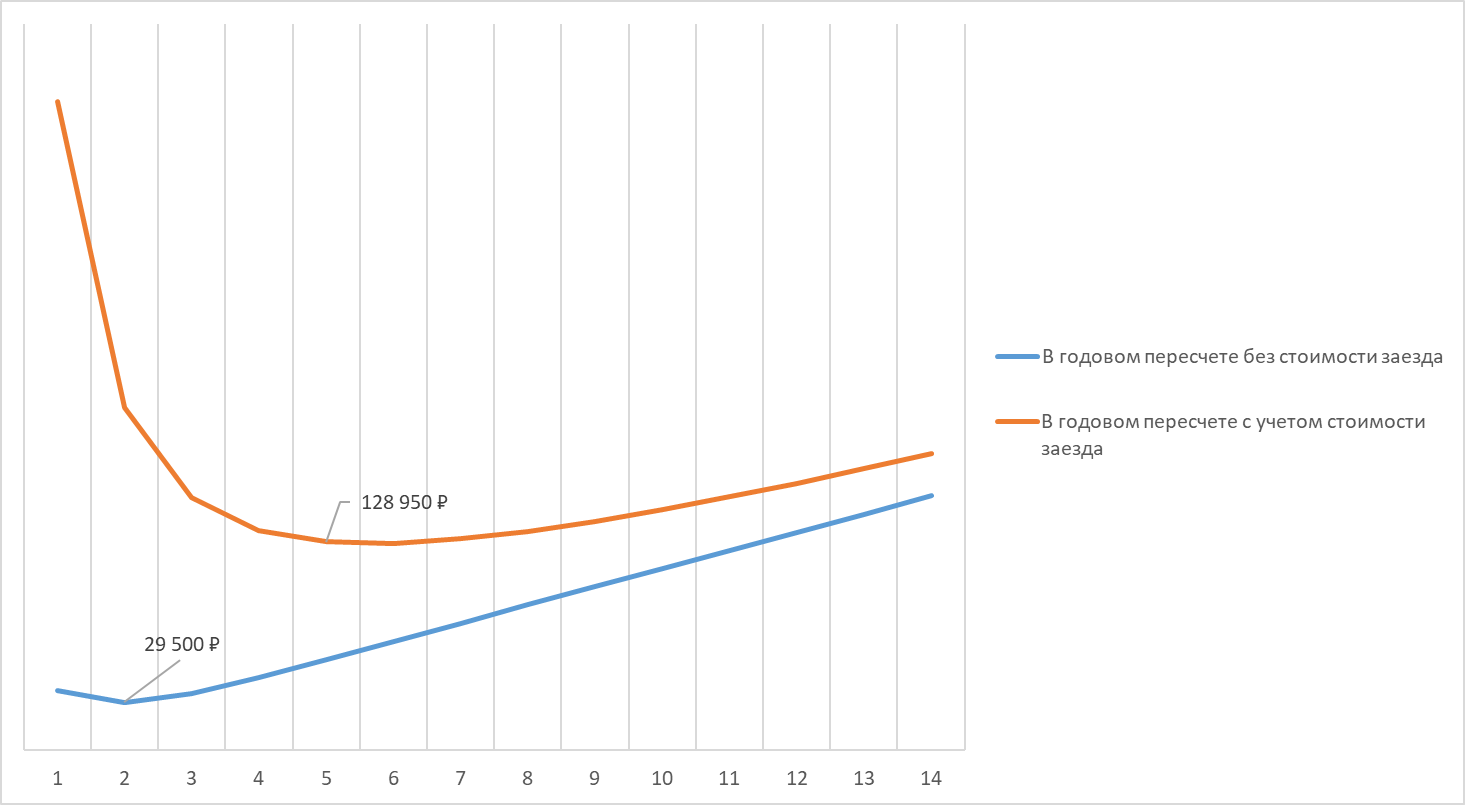

**Рассчитаем матрицу расходов для каждого терминала и найдем оптимальный день для инкассации каждого терминала**

Не учитываем стоимость за заезд (файл excel с примером расчета приложу)

In [15]:
columns = ['TID','Средний прирост','День','Стоимость фондирования','С учетом пересчета','Годовые расходы','Стоимость пересчета']
day_d = pd.DataFrame(columns = columns)
day_d.loc[0,'День'] = '1'
day_d.loc[1,'День'] = '2'
day_d.loc[2,'День'] = '3'
day_d.loc[3,'День'] = '4'
day_d.loc[4,'День'] = '5'
day_d.loc[5,'День'] = '6'
day_d.loc[6,'День'] = '7'
day_d.loc[7,'День'] = '8'
day_d.loc[8,'День'] = '9'
day_d.loc[9,'День'] = '10'
day_d.loc[10,'День'] = '11'
day_d.loc[11,'День'] = '12'
day_d.loc[12,'День'] = '13'
day_d.loc[13,'День'] = '14'

In [16]:
day_d

,TID,Средний прирост,День,Стоимость фондирования,С учетом пересчета,Годовые расходы,Стоимость пересчета
0,NaN,NaN,1,NaN,NaN,NaN,NaN
1,NaN,NaN,2,NaN,NaN,NaN,NaN
2,NaN,NaN,3,NaN,NaN,NaN,NaN
3,NaN,NaN,4,NaN,NaN,NaN,NaN
4,NaN,NaN,5,NaN,NaN,NaN,NaN
5,NaN,NaN,6,NaN,NaN,NaN,NaN
6,NaN,NaN,7,NaN,NaN,NaN,NaN
7,NaN,NaN,8,NaN,NaN,NaN,NaN
8,NaN,NaN,9,NaN,NaN,NaN,NaN
9,NaN,NaN,10,NaN,NaN,NaN,NaN


Алгоритм формирования данной матрицы для каждого терминала.
1. Здесь мы находим минимум, при котором инкассация будет самой минимальной
2. В таблице присваиваем каждому терминалу значения дня инкассации
3. Данное значение будет меняться в динамике по мере изменения значения дневного прироста

In [17]:
day_d_df = pd.DataFrame(columns = columns)
for i in range(0, len(df_incomes)):
    day_d['TID'] = df_incomes.loc[i,'TID']
    day_d['Средний прирост'] = df_incomes.loc[i,'Median']
    for row in range (0,len(day_d)):
        if row == 0:
            day_d.loc[row,'Стоимость фондирования'] = 0
        elif row == 1:
            day_d.loc[row,'Стоимость фондирования'] = day_d.loc[row,'Средний прирост']*fond
        else:
            day_d.loc[row,'Стоимость фондирования'] = day_d.loc[row-1,'Стоимость фондирования'] + day_d.loc[row,'Средний прирост']*row*fond

        # Ставка пересчета
        if day_d.loc[row,'Средний прирост']*stavka*(row+1) < 100:
            st = min_inc
        else:
            st = day_d.loc[row,'Средний прирост']*stavka*(row+1)
        # Смотри описание расчета в файле excel Инкассация терминалов Лист 3
        day_d.loc[row,'С учетом пересчета'] = day_d.loc[row,'Стоимость фондирования']+st+st_zaezd
        day_d.loc[row,'Годовые расходы'] = day_d.loc[row,'С учетом пересчета']*(day_period/(row+1))
        day_d.loc[row,'Стоимость пересчета'] = st
        # Находим минимальный день день для инкассации
    df_incomes.loc[i,'День инкассации'] = day_d.loc[day_d['Годовые расходы'] == day_d['Годовые расходы'].min(),'День'].values[0]
    day_d_df = pd.concat([day_d_df,day_d],ignore_index=True)

In [18]:
df_incomes.head(2)

,TID,остаток на 31.08.2022 (входящий),2022-09-01 00:00:00,2022-09-02 00:00:00,2022-09-03 00:00:00,2022-09-04 00:00:00,2022-09-05 00:00:00,2022-09-06 00:00:00,2022-09-07 00:00:00,2022-09-08 00:00:00,...,2022-11-23 00:00:00,2022-11-24 00:00:00,2022-11-25 00:00:00,2022-11-26 00:00:00,2022-11-27 00:00:00,2022-11-28 00:00:00,2022-11-29 00:00:00,2022-11-30 00:00:00,Median,День инкассации
0,406136,160000,90000,105000,99000,107000,110000,60000,75000,89000,...,0,165000,0,189000,106000,94000,75000,74000,225000,2
1,406139,387000,103000,206000,168000,124000,78000,165000,164000,174000,...,151000,157000,206000,182000,123000,138000,112000,179000,374000,2


In [20]:
day_d_df.head(2)

,TID,Средний прирост,День,Стоимость фондирования,С учетом пересчета,Годовые расходы,Стоимость пересчета
0,406136,225000,1,0,100,36500.0,100
1,406136,225000,2,45.924658,145.924658,26631.25,100


**Создадим файл с датами последней инкассации**

In [24]:
inc_last_day = df_incomes.iloc[:,[0,1,len(df_incomes.columns)-2,len(df_incomes.columns)-1]]
inc_last_day.head(2)

,TID,остаток на 31.08.2022 (входящий),Median,День инкассации
0,406136,160000,225000,2
1,406139,387000,374000,2


**Найдем для каждого терминала, сколько дней он не инкассировался с учетом текущего остатка и информации о среднем дневном приросте**

- Здесь вместо данных о количестиве дней без инкассации в дальнейшем необходимо прикрутить дату последней инкассации. ЧТобы данные были более достоверными

In [27]:
# По опыту скажу, округление лучше делать на стороне БД, либо преобразовывать в формат decimal. однако и здесь 
# часто происходит проблема с округлением. После вычислений двух чисел decimal, питон часто преобразовывает его во
# float необходимо контролировать тип данных на всех этапах вычислений и округления
inc_last_day['Дней без инкассации'] = round(inc_last_day.iloc[:,1]/inc_last_day['Median']).astype('int')
inc_last_day['День инкассации'] = inc_last_day['День инкассации'].astype('int') 
inc_last_day['Отклонение'] = inc_last_day['Дней без инкассации']-inc_last_day['День инкассации']
inc_last_day.head(2)

C:\Users\Windows\AppData\Local\Temp\ipykernel_15428\963486541.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inc_last_day['Дней без инкассации'] = round(inc_last_day.iloc[:,1]/inc_last_day['Median']).astype('int')
C:\Users\Windows\AppData\Local\Temp\ipykernel_15428\963486541.py:5: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inc_last_day['День инкассации'] = inc_last_day['День инкассации'].astype('int')
C:\Users\Windows\AppData\Local\Temp\ipykernel_15428\963486541.py:6: SettingWithCopyWarning: 
A valu

,TID,остаток на 31.08.2022 (входящий),Median,День инкассации,Дней без инкассации,Отклонение
0,406136,160000,225000,2,1,-1
1,406139,387000,374000,2,1,-1


**Создадим матрицу инкассации**

Было принято решение сделать 3 статуса для терминалов
- red
- orange
- green

**Статус red попадают терминалы если:**
1. Остаток больше 1 млн
2. Без инкассации более 14 дней
3. Если сумма текущего остатка и дневного прироста более 1 млн
4. Если отклонения от желаемой инкассации > = 0

**Статус orange**
1. Отклонение = -1. Режим плановой инкассации

**Статус green**
- Если остаток меньше дневного прироста
- Все остальные терминалы, которые не требуют инкассации

In [29]:
# Терминалы для инкассации
# Это первый приоритет
# Если объем более 1 млн
sum_max = 1000000
# Более 14 дней
day_max = 14
# Вышел за лимит дня (текущая выручка + медиана)
# Если отклонение >=0
otk = 0
# Обычный приоритет инкассация по плану
otk_norm = -1
inc_last_day['Статус'] = ''
inc_last_day['Статус_1'] = ''
inc_last_day['Статус_2'] = ''
for row in range(0,len(inc_last_day)):
    # Первый приоритет
    if (inc_last_day.iloc[row,1] >=sum_max) or \
    (inc_last_day.loc[row,'Дней без инкассации'] > day_max) or \
    (inc_last_day.iloc[row,1] + inc_last_day.loc[row,'Median']  >= sum_max) or \
    (inc_last_day.loc[row,'Отклонение'] >= otk):
        inc_last_day.loc[row,'Статус'] = 'red'
    # Второй приоритет инкассации
    elif inc_last_day.loc[row,'Отклонение'] == otk_norm:
        if inc_last_day.iloc[row,1] < inc_last_day.loc[row,'Median']:
            inc_last_day.loc[row,'Статус_2'] = 'green'
        else:    
            inc_last_day.loc[row,'Статус_1'] = 'orange'
    else:
        inc_last_day.loc[row,'Статус_2'] = 'green'

C:\Users\Windows\AppData\Local\Temp\ipykernel_15428\394829895.py:12: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inc_last_day['Статус'] = ''
C:\Users\Windows\AppData\Local\Temp\ipykernel_15428\394829895.py:13: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  inc_last_day['Статус_1'] = ''
C:\Users\Windows\AppData\Local\Temp\ipykernel_15428\394829895.py:14: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See th

In [30]:
inc_last_day.head(5)

,TID,остаток на 31.08.2022 (входящий),Median,День инкассации,Дней без инкассации,Отклонение,Статус,Статус_1,Статус_2
0,406136,160000,225000,2,1,-1,,,green
1,406139,387000,374000,2,1,-1,,orange,
2,406145,287000,380000,2,1,-1,,,green
3,406148,355000,143000,3,2,-1,,orange,
4,406180,597000,180000,2,3,1,red,,


**Выводим точки для инкассации в файл, который далее будет использоваться для построения маршрутов**

In [32]:
inc_last_day.to_excel('test_point_inc.xlsx')

In [33]:
inc_last_day

,TID,остаток на 31.08.2022 (входящий),Median,День инкассации,Дней без инкассации,Отклонение,Статус,Статус_1,Статус_2
0,406136,160000,225000,2,1,-1,,,green
1,406139,387000,374000,2,1,-1,,orange,
2,406145,287000,380000,2,1,-1,,,green
3,406148,355000,143000,3,2,-1,,orange,
4,406180,597000,180000,2,3,1,red,,
...,...,...,...,...,...,...,...,...,...
1625,699578,47000,55000,4,1,-3,,,green
1626,699579,236000,190000,2,1,-1,,orange,
1627,699629,67000,121000,3,1,-2,,,green
1628,699641,278000,96000,3,3,0,red,,
